In [1]:
# Generative Adversarial Network (GAN) on MNIST Dataset with Modified DCGAN Architecture for (28 x 28) MNIST Images #

In [2]:
# Increasing the Cell Width of Jupyter Notebook

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Importing Libraries

import os
import torch
import shutil
import tarfile
import torchvision
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
%matplotlib inline

In [4]:
# Image Size of MNIST: (1 x 28 x 28) || Batch Size: 128 || Mean & Std Values: 0.5

image_size = 28
batch_size = 128
stats = ((0.5), (0.5))

In [5]:
# Defining the Dataset and Data Loader for GAN

transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)])

train_ds = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 264407573.37it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 33667508.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 236934852.05it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4992276.93it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# Defining Functions to Plot Images

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 1, 1, 1)
    stds = torch.tensor(stds).reshape(1, 1, 1, 1)
    return images.cpu() * stds + means


def plot_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(int(nmax/8), 8))
    ax.set_xticks([]);
    ax.set_yticks([])
    ax.imshow(make_grid(denormalize(images.detach()[:nmax], *stats), nrow=int(nmax/8)).permute(1, 2, 0))


def plot_batch(dl, nmax=64):
    for images, _ in dl:
        plot_images(images, nmax)
        break

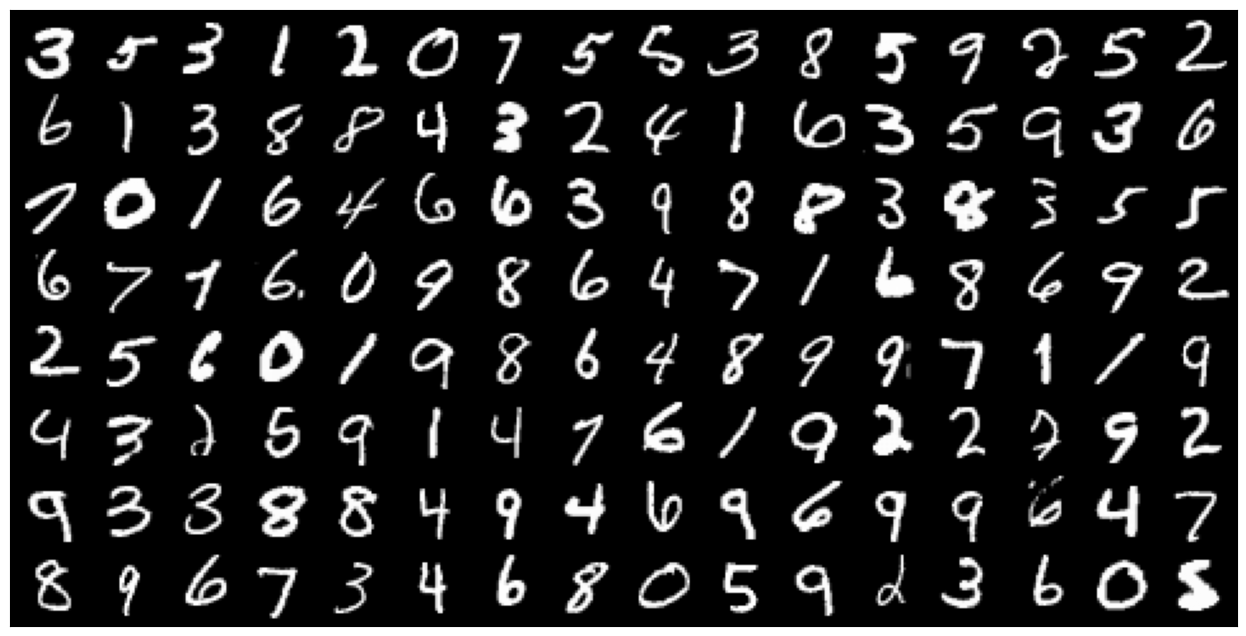

In [7]:
# Plotting 1 Batch of Images from the Data Loader as Grid

plot_batch(train_dl, batch_size)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple, set)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
# Sending the Data Loader to the Current Device

train_dl = DeviceDataLoader(train_dl, device)

In [10]:
in_channels = 1        # CIFAR-10 Dataset Has 3-Channel Images with 32x32 Size
latent_size = 128      # Latent Size of 1x1 Input Samples for the GAN to Generate 32x32 Images

In [11]:
# Definition of the Discriminator Network

class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        # input:  N x 1 x 28 x 28
        self.block_1 = nn.Sequential(
                       nn.Conv2d(in_channels, 128, kernel_size=4, stride=2, padding=1, bias=False),
                       nn.LeakyReLU(0.2, inplace=True))
        # output: N x 128 x 14 x 14
        self.block_2 = nn.Sequential(
                       nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
                       nn.BatchNorm2d(256),
                       nn.LeakyReLU(0.2, inplace=True))
        # output: N x 256 x 7 x 7
        self.block_3 = nn.Sequential(
                       nn.Conv2d(256, 256, kernel_size=4, stride=1, padding=2, bias=False),
                       nn.BatchNorm2d(256),
                       nn.LeakyReLU(0.2, inplace=True),
        # output: N x 128 x 8 x 8
                       nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
                       nn.BatchNorm2d(512),
                       nn.LeakyReLU(0.2, inplace=True))
        # output: N x 512 x 4 x 4
        self.block_f = nn.Sequential(
                       nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
        # output: N x 1 x 1 x 1
                       nn.Flatten(),
                       nn.Sigmoid())
        # output: N x 1

    def forward(self, xb):
        out = self.block_1(xb)
        out = self.block_2(out)
        out = self.block_3(out)
        out = self.block_f(out)
        return out

In [12]:
# Creating the Discriminator Network to Predict if the Generated Images are Real or Fake

discriminator = to_device(Discriminator(in_channels), device)

In [13]:
# Definition of the Generator Network

class Generator(nn.Module):
    def __init__(self, latent_size, in_channels):
        super(Generator, self).__init__()
        # input:  N x latent_size x 1 x 1
        self.blockt_1 = nn.Sequential(
                        nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
                        nn.BatchNorm2d(512),
                        nn.ReLU(True))
        # output: N x 512 x 4 x 4
        self.blockt_2 = nn.Sequential(
                        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True))
        # output: N x 256 x 8 x 8
        self.blockt_3 = nn.Sequential(
                        nn.ConvTranspose2d(256, 256, kernel_size=4, stride=1, padding=2, bias=False),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True),
        # output: N x 256 x 7 x 7
                        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.BatchNorm2d(128),
                        nn.ReLU(True))
        # output: N x 128 x 14 x 14
        self.blockt_f = nn.Sequential(
                        nn.ConvTranspose2d(128, in_channels, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.Tanh())
        # output: N x 1 x 28 x 28

    def forward(self, xb):
        out = self.blockt_1(xb)
        out = self.blockt_2(out)
        out = self.blockt_3(out)
        out = self.blockt_f(out)
        return out

In [14]:
# Creating the Generator Network to Generate 32x32 New CIFAR Images Which are Checked by the Discriminator Network to Predict If They are Real or Fake

generator = to_device(Generator(latent_size, in_channels), device)

torch.Size([128, 1, 28, 28])


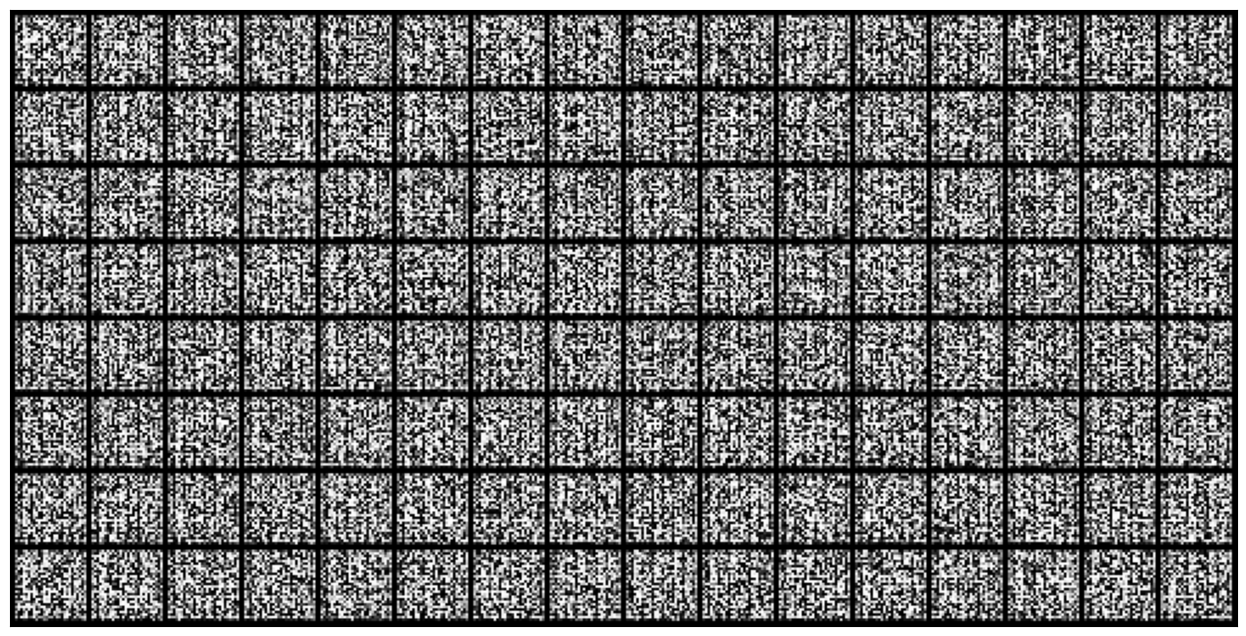

In [15]:
# Plotting a Batch Number of Fake Images Generated from the Input Latent Tensor Before the Training

fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = generator(fixed_latent)
print(fake_images.shape)
plot_images(fake_images, batch_size)

In [16]:
# Trainer Function for the Discriminator

def train_discriminator(real_images, opt_d):
    # Clearing Discriminator Gradients
    opt_d.zero_grad()

    # Passing Real Images Through the Discriminator
    real_preds = discriminator(real_images)                             # Real Predictions from Real Images
    real_targets = torch.ones(real_images.size(0), 1, device=device)    # Real Targets are Represented with 1
    real_loss = F.binary_cross_entropy(real_preds, real_targets)        # Real Loss is Evaluated
    real_score = torch.mean(real_preds).item()                          # Real Score is Evaluated

    # Generating Fake Images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Generating Latent Input from Random Torch Values
    fake_images = generator(latent)                                     # Generating Fake Images by the Generator Network

    # Passing Fake Images Through the Discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)   # Fake Targets are Represented with 0
    fake_preds = discriminator(fake_images)                             # Fake Predictions from Fake Images
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)        # Fake Loss is Evaluated
    fake_score = torch.mean(fake_preds).item()                          # Fake Score is Evaluated

    # Updating the Discriminator Weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [17]:
# Trainer Function for the Generator

def train_generator(opt_g):
    # Clear Generator Gradients
    opt_g.zero_grad()

    # Generating Fake Images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Creating Random Latent Tensor
    fake_images = generator(latent)                                     # Generating Fake Images from the Latent Tensor

    # Trying to Fool the Discriminator
    preds = discriminator(fake_images)                                  # Predictions from Fake Images
    targets = torch.ones(batch_size, 1, device=device)                  # Targets are Represented with 1
    loss = F.binary_cross_entropy(preds, targets)                       # Loss is Evaluated

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [18]:
# Creating a Folder to Store the Sample Images Generated Throughout the Training Process

sample_dir = "./generated"
os.makedirs(sample_dir, exist_ok=True)

In [19]:
# Definition of a Function to Save the Generated Sample Images per Epoch

def save_samples(index, latent_tensors, nmax=64, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denormalize(fake_images, *stats), os.path.join(sample_dir, fake_fname), nrow=int(nmax/8))
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(int(nmax/8), 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denormalize(fake_images, *stats), nrow=int(nmax/8)).permute(1, 2, 0).clip(0, 1))

Saving generated-images-0000.png


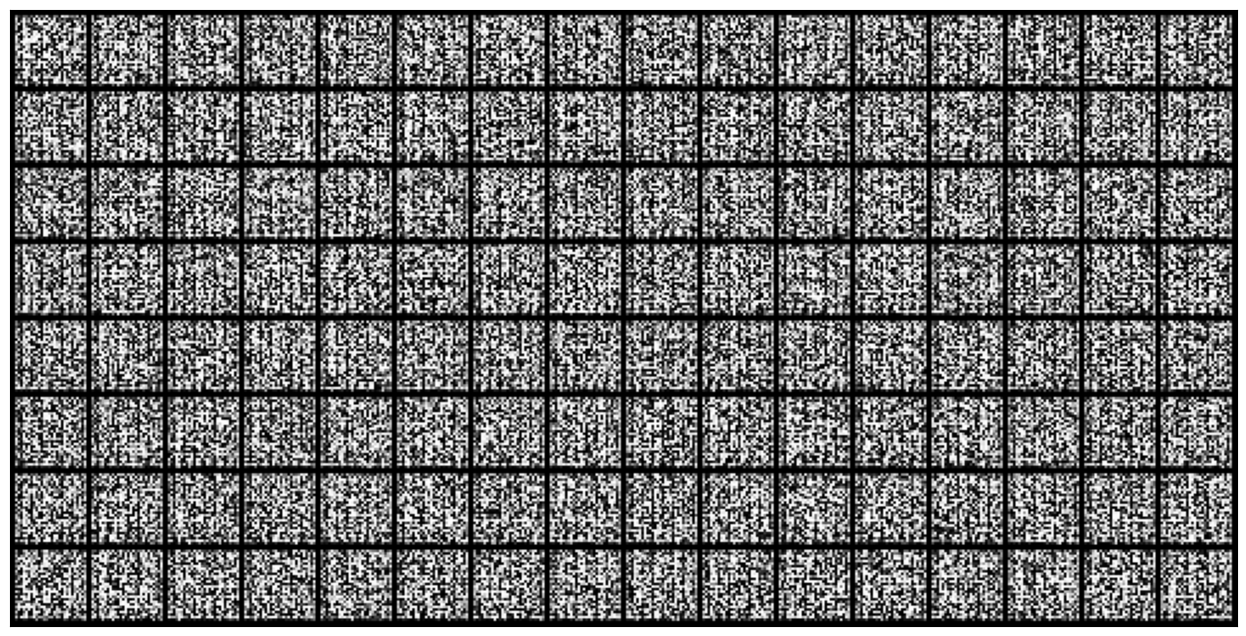

In [20]:
# Saving a Batch Number of Sample Fake Images Generated from the Fixed Latent Tensor

save_samples(0, fixed_latent, fixed_latent.size(0))

In [21]:
# Definition of the fit() Function to Train Generator & Discriminator Networks

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Loss Lists & Score Lists
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Training Discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Training Generator
            loss_g = train_generator(opt_g)

        # Recording Losses & Scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Logging the Losses & Scores (the Last Batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Saving the Generated Images
        save_samples(epoch+start_idx, fixed_latent, fixed_latent.size(0), show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [22]:
lr = 0.0002         # Learning Rate
epochs = 70         # Number of Epochs

In [23]:
# Training Process

history = fit(epochs, lr)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [1/70], loss_g: 0.9881, loss_d: 0.9838, real_score: 0.5332, fake_score: 0.0980
Saving generated-images-0001.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [2/70], loss_g: 0.3997, loss_d: 1.5071, real_score: 0.2758, fake_score: 0.0799
Saving generated-images-0002.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [3/70], loss_g: 0.7395, loss_d: 0.9419, real_score: 0.4907, fake_score: 0.1225
Saving generated-images-0003.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [4/70], loss_g: 0.7755, loss_d: 0.9569, real_score: 0.5814, fake_score: 0.2589
Saving generated-images-0004.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [5/70], loss_g: 1.4081, loss_d: 0.8961, real_score: 0.7128, fake_score: 0.3689
Saving generated-images-0005.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [6/70], loss_g: 0.5004, loss_d: 1.1063, real_score: 0.4304, fake_score: 0.0846
Saving generated-images-0006.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [7/70], loss_g: 1.7582, loss_d: 0.6181, real_score: 0.7130, fake_score: 0.1884
Saving generated-images-0007.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [8/70], loss_g: 3.0271, loss_d: 0.7270, real_score: 0.9300, fake_score: 0.4388
Saving generated-images-0008.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [9/70], loss_g: 2.7157, loss_d: 0.4397, real_score: 0.8312, fake_score: 0.2024
Saving generated-images-0009.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [10/70], loss_g: 1.5581, loss_d: 0.7489, real_score: 0.5509, fake_score: 0.0747
Saving generated-images-0010.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [11/70], loss_g: 1.5758, loss_d: 0.5328, real_score: 0.7289, fake_score: 0.1506
Saving generated-images-0011.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [12/70], loss_g: 1.4294, loss_d: 0.5901, real_score: 0.6533, fake_score: 0.1065
Saving generated-images-0012.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [13/70], loss_g: 2.6186, loss_d: 0.4036, real_score: 0.9130, fake_score: 0.2385
Saving generated-images-0013.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [14/70], loss_g: 3.4759, loss_d: 0.4924, real_score: 0.7606, fake_score: 0.1546
Saving generated-images-0014.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [15/70], loss_g: 1.0275, loss_d: 0.5194, real_score: 0.7231, fake_score: 0.1309
Saving generated-images-0015.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [16/70], loss_g: 2.7324, loss_d: 0.9778, real_score: 0.9253, fake_score: 0.5150
Saving generated-images-0016.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [17/70], loss_g: 2.2844, loss_d: 0.2991, real_score: 0.7886, fake_score: 0.0403
Saving generated-images-0017.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [18/70], loss_g: 5.5686, loss_d: 0.6089, real_score: 0.9396, fake_score: 0.3752
Saving generated-images-0018.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [19/70], loss_g: 3.4376, loss_d: 0.3492, real_score: 0.9585, fake_score: 0.2458
Saving generated-images-0019.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [20/70], loss_g: 2.6242, loss_d: 0.2811, real_score: 0.8586, fake_score: 0.0982
Saving generated-images-0020.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [21/70], loss_g: 1.9429, loss_d: 0.3639, real_score: 0.8501, fake_score: 0.1562
Saving generated-images-0021.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [22/70], loss_g: 3.0078, loss_d: 0.5621, real_score: 0.9896, fake_score: 0.3663
Saving generated-images-0022.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [23/70], loss_g: 2.6915, loss_d: 0.4165, real_score: 0.9422, fake_score: 0.2568
Saving generated-images-0023.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [24/70], loss_g: 2.5520, loss_d: 0.1307, real_score: 0.9054, fake_score: 0.0255
Saving generated-images-0024.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [25/70], loss_g: 4.4928, loss_d: 0.4939, real_score: 0.9641, fake_score: 0.3312
Saving generated-images-0025.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [26/70], loss_g: 3.2443, loss_d: 0.3245, real_score: 0.7962, fake_score: 0.0362
Saving generated-images-0026.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [27/70], loss_g: 3.2793, loss_d: 0.6882, real_score: 0.7609, fake_score: 0.2619
Saving generated-images-0027.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [28/70], loss_g: 4.4087, loss_d: 2.8360, real_score: 0.9956, fake_score: 0.8699
Saving generated-images-0028.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [29/70], loss_g: 5.8112, loss_d: 0.3953, real_score: 0.9900, fake_score: 0.2819
Saving generated-images-0029.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [30/70], loss_g: 3.6410, loss_d: 0.4194, real_score: 0.7102, fake_score: 0.0222
Saving generated-images-0030.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [31/70], loss_g: 2.2649, loss_d: 0.3724, real_score: 0.7794, fake_score: 0.0763
Saving generated-images-0031.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [32/70], loss_g: 4.8020, loss_d: 0.2963, real_score: 0.9669, fake_score: 0.2044
Saving generated-images-0032.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [33/70], loss_g: 2.9239, loss_d: 0.6061, real_score: 0.8085, fake_score: 0.2706
Saving generated-images-0033.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [34/70], loss_g: 3.0879, loss_d: 0.2030, real_score: 0.8528, fake_score: 0.0346
Saving generated-images-0034.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [35/70], loss_g: 2.1225, loss_d: 0.2130, real_score: 0.8709, fake_score: 0.0558
Saving generated-images-0035.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [36/70], loss_g: 5.6426, loss_d: 0.5410, real_score: 0.9931, fake_score: 0.3705
Saving generated-images-0036.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [37/70], loss_g: 5.1035, loss_d: 0.2655, real_score: 0.8796, fake_score: 0.1058
Saving generated-images-0037.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [38/70], loss_g: 1.7657, loss_d: 0.1827, real_score: 0.9297, fake_score: 0.0866
Saving generated-images-0038.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [39/70], loss_g: 3.4456, loss_d: 0.2339, real_score: 0.9846, fake_score: 0.1718
Saving generated-images-0039.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [40/70], loss_g: 5.6891, loss_d: 0.6863, real_score: 0.9657, fake_score: 0.4078
Saving generated-images-0040.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [41/70], loss_g: 7.1180, loss_d: 0.3589, real_score: 0.9981, fake_score: 0.2764
Saving generated-images-0041.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [42/70], loss_g: 0.3278, loss_d: 2.0972, real_score: 0.1821, fake_score: 0.0003
Saving generated-images-0042.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [43/70], loss_g: 3.5063, loss_d: 0.3220, real_score: 0.9900, fake_score: 0.2236
Saving generated-images-0043.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [44/70], loss_g: 2.7665, loss_d: 0.3186, real_score: 0.8260, fake_score: 0.0879
Saving generated-images-0044.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [45/70], loss_g: 2.9091, loss_d: 0.2000, real_score: 0.8578, fake_score: 0.0265
Saving generated-images-0045.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [46/70], loss_g: 3.9181, loss_d: 0.1741, real_score: 0.9939, fake_score: 0.1422
Saving generated-images-0046.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [47/70], loss_g: 6.1326, loss_d: 0.1115, real_score: 0.9560, fake_score: 0.0586
Saving generated-images-0047.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [48/70], loss_g: 5.8860, loss_d: 0.0854, real_score: 0.9914, fake_score: 0.0703
Saving generated-images-0048.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [49/70], loss_g: 4.2533, loss_d: 0.3172, real_score: 0.7579, fake_score: 0.0092
Saving generated-images-0049.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [50/70], loss_g: 3.2938, loss_d: 0.2228, real_score: 0.8873, fake_score: 0.0879
Saving generated-images-0050.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [51/70], loss_g: 6.8625, loss_d: 0.8102, real_score: 0.9914, fake_score: 0.4607
Saving generated-images-0051.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [52/70], loss_g: 6.0494, loss_d: 0.1181, real_score: 0.9654, fake_score: 0.0702
Saving generated-images-0052.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [53/70], loss_g: 2.0331, loss_d: 3.5716, real_score: 0.1777, fake_score: 0.0067
Saving generated-images-0053.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [54/70], loss_g: 4.4562, loss_d: 0.1621, real_score: 0.9920, fake_score: 0.1344
Saving generated-images-0054.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [55/70], loss_g: 2.0315, loss_d: 0.2064, real_score: 0.8560, fake_score: 0.0276
Saving generated-images-0055.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [56/70], loss_g: 3.7404, loss_d: 0.3257, real_score: 0.8480, fake_score: 0.1074
Saving generated-images-0056.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [57/70], loss_g: 5.3073, loss_d: 0.3569, real_score: 0.9620, fake_score: 0.2343
Saving generated-images-0057.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [58/70], loss_g: 4.0479, loss_d: 0.0805, real_score: 0.9518, fake_score: 0.0271
Saving generated-images-0058.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [59/70], loss_g: 1.2302, loss_d: 0.3612, real_score: 0.7316, fake_score: 0.0128
Saving generated-images-0059.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [60/70], loss_g: 0.4319, loss_d: 0.6916, real_score: 0.5881, fake_score: 0.0045
Saving generated-images-0060.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [61/70], loss_g: 4.8578, loss_d: 0.1652, real_score: 0.9882, fake_score: 0.1294
Saving generated-images-0061.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [62/70], loss_g: 3.1959, loss_d: 0.1244, real_score: 0.9350, fake_score: 0.0508
Saving generated-images-0062.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [63/70], loss_g: 2.7221, loss_d: 0.2341, real_score: 0.9951, fake_score: 0.1716
Saving generated-images-0063.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [64/70], loss_g: 4.8509, loss_d: 0.0879, real_score: 0.9802, fake_score: 0.0627
Saving generated-images-0064.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [65/70], loss_g: 4.4737, loss_d: 0.0724, real_score: 0.9516, fake_score: 0.0202
Saving generated-images-0065.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [66/70], loss_g: 5.1356, loss_d: 0.0827, real_score: 0.9573, fake_score: 0.0341
Saving generated-images-0066.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [67/70], loss_g: 7.2069, loss_d: 0.4251, real_score: 0.8877, fake_score: 0.2099
Saving generated-images-0067.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [68/70], loss_g: 4.9515, loss_d: 0.0452, real_score: 0.9836, fake_score: 0.0249
Saving generated-images-0068.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [69/70], loss_g: 3.8277, loss_d: 0.0553, real_score: 0.9701, fake_score: 0.0229
Saving generated-images-0069.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [70/70], loss_g: 6.5293, loss_d: 0.0129, real_score: 0.9957, fake_score: 0.0085
Saving generated-images-0070.png


In [24]:
# Getting Loss Lists and Score Lists from the Result of Running the fit() Function

losses_g, losses_d, real_scores, fake_scores = history

In [25]:
# Saving the Model Weights

torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

# Example Codes to Load the Saved Model Weights
#generator.load_state_dict(torch.load('G.pth'))
#discriminator.load_state_dict(torch.load('D.pth'))

torch.Size([128, 1, 28, 28])


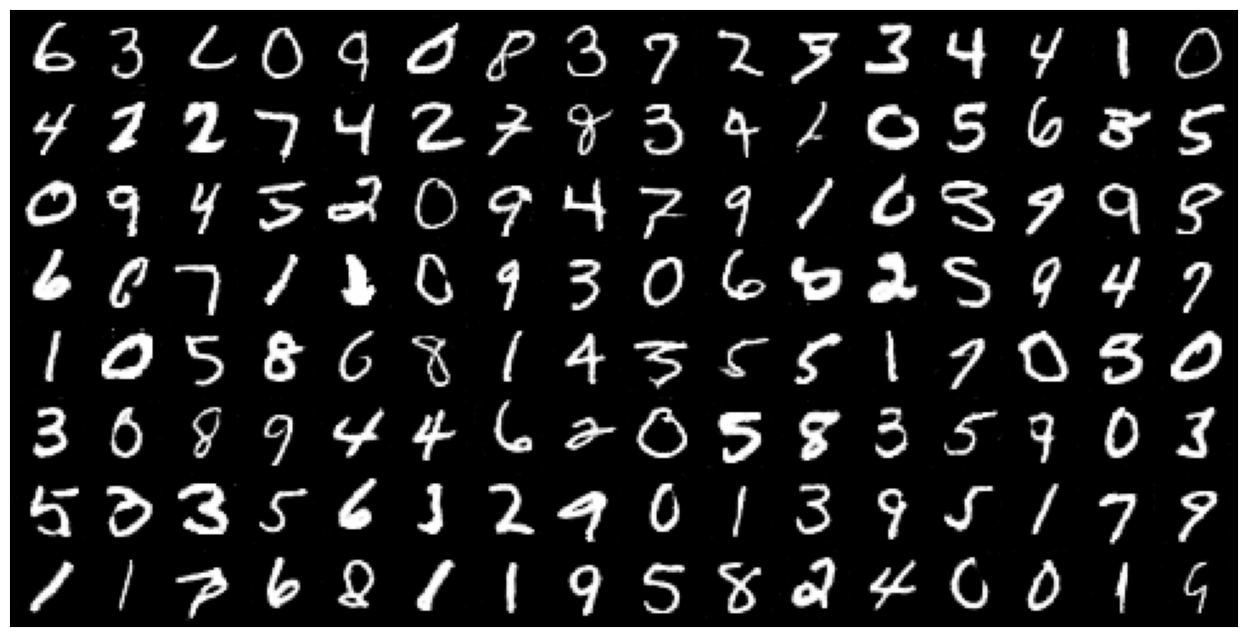

In [26]:
# Plotting a Batch Number of Fake Images Generated from the Input Latent Tensor After the Training

#fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = generator(fixed_latent)
print(fake_images.shape)
plot_images(fake_images, batch_size)

In [27]:
# Showing the Saved Images

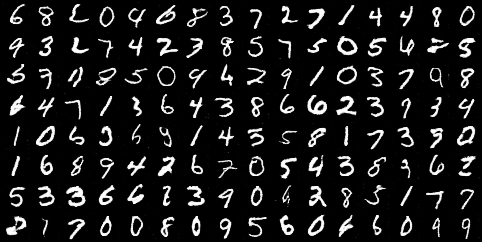

In [28]:
Image('./generated/generated-images-0015.png', height=620)

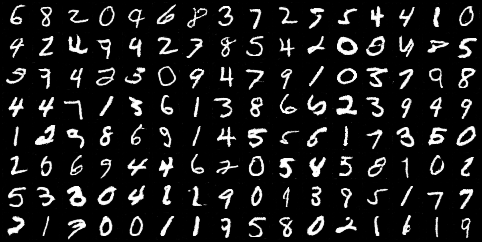

In [29]:
Image('./generated/generated-images-0030.png', height=620)

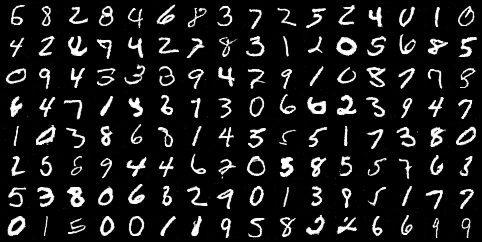

In [30]:
Image('./generated/generated-images-0045.png', height=620)

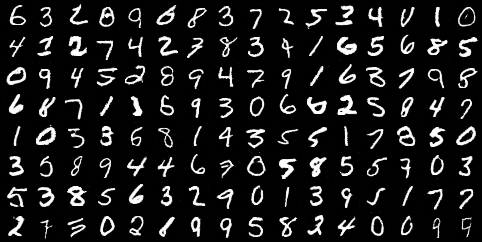

In [31]:
Image('./generated/generated-images-0060.png', height=620)

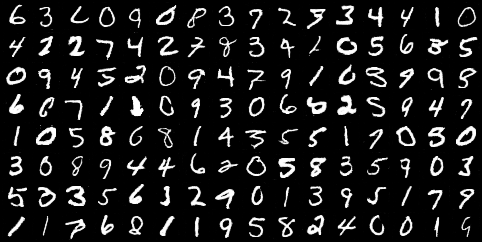

In [32]:
Image('./generated/generated-images-0070.png', height=620)

In [33]:
# Saving a Video of Generated Image Samples Which Shows the Progress of Training the Networks

import cv2
import os

sample_dir = "./generated"
vid_fname = "./gans_training.avi"

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

size = (1240, 620)

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MJPG'),  10, size)
[out.write(cv2.resize(cv2.imread(fname), size)) for fname in files]
out.release()

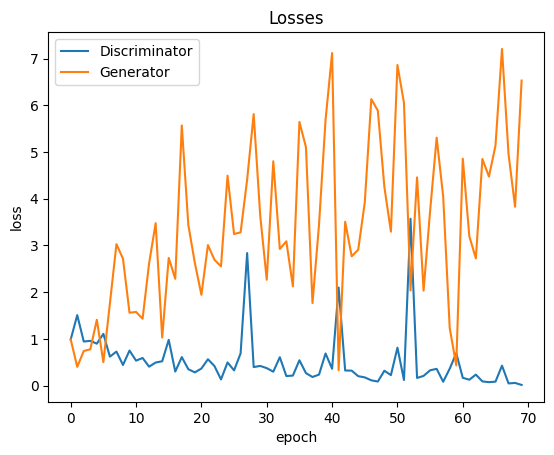

In [34]:
# Plotting the Loss Values per Epoch for Both Generator and Discriminator

plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

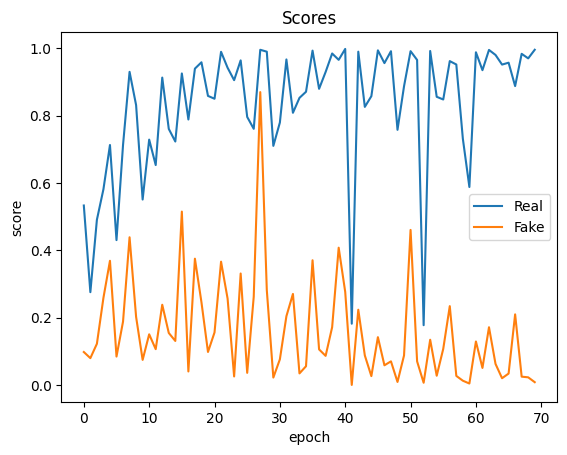

In [35]:
# Plotting Both Real and Fake Scores per Epoch

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

torch.Size([128, 1, 28, 28])


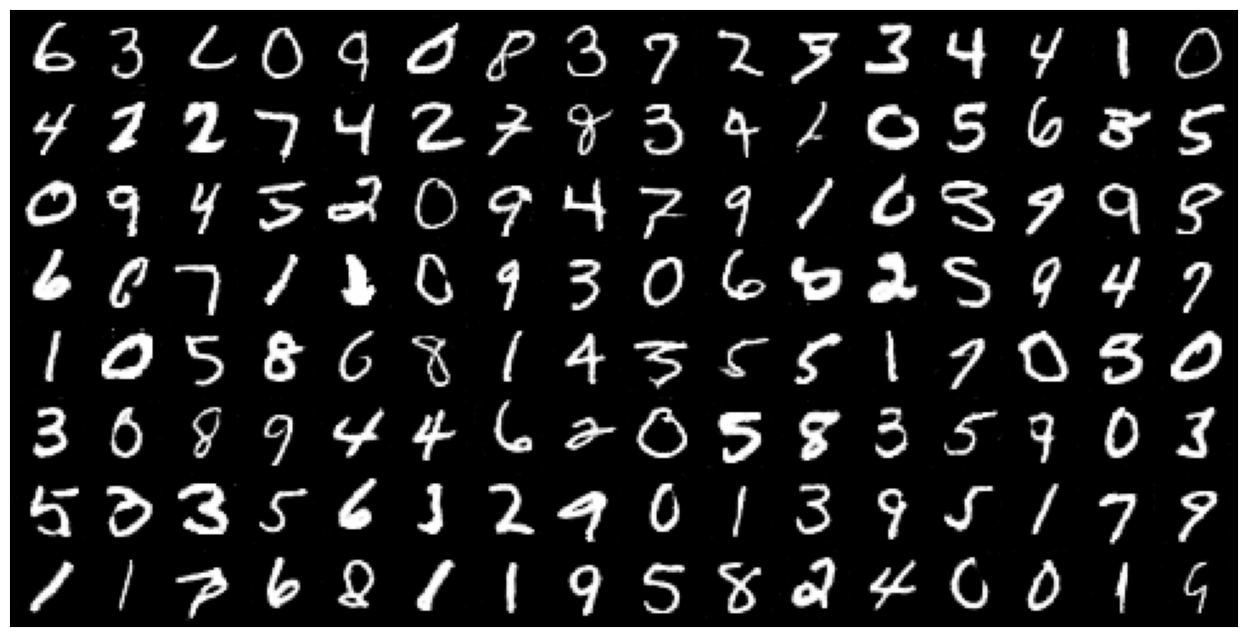

In [36]:
# Definition of a New Generator and a New Discriminator Models to Load the Pre-Saved Model Weights (.pth)

generator_new = Generator(latent_size, in_channels).to(device)
discriminator_new = Discriminator(in_channels).to(device)

generator_new.load_state_dict(torch.load('G.pth'))
discriminator_new.load_state_dict(torch.load('D.pth'))

#--------------------------------------------------------

# Plotting a Batch Number of Fake Images Generated by the New Model from the Input Latent Tensor After the Training

#fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = generator(fixed_latent)
fake_images_new = generator_new(fixed_latent)

print(fake_images_new.shape)
plot_images(fake_images_new, fake_images_new.size(0))

In [37]:
# Showing That the Discriminator Networks of Both the Two Models Give the Same Prediction Results After Loading the Saved Weights to the New Model

# Printing Only 8 Values to Demonstrate the Identicality
print(f"Discriminator Predictions of the Original Model:\n{discriminator(fake_images)[:8].cpu().detach().numpy()}\n")
print(f"Discriminator Predictions of the New Model:\n{discriminator(fake_images_new)[:8].cpu().detach().numpy()}\n")

Discriminator Predictions of the Original Model:
[[3.8462708e-04]
 [1.3187615e-03]
 [5.2779779e-04]
 [3.4600560e-04]
 [4.5091701e-03]
 [8.2371174e-04]
 [1.8341065e-04]
 [1.8963321e-05]]

Discriminator Predictions of the New Model:
[[3.8462578e-04]
 [1.3187603e-03]
 [5.2779855e-04]
 [3.4600549e-04]
 [4.5091291e-03]
 [8.2370697e-04]
 [1.8340889e-04]
 [1.8963250e-05]]



In [38]:
# Zipping the "generated" Folder to Download (Optional)

!zip -r ./generated.zip ./generated &> /dev/null

In [39]:
# Downloading Files (for Colab Runtime)
#   generated.zip
#   gans_training.avi
#   G.pth & D.pth

from google.colab import files as colabfiles

if os.path.isfile("generated.zip"):
    colabfiles.download("generated.zip")
if os.path.isfile("gans_training.avi"):
    colabfiles.download("gans_training.avi")
if os.path.isfile("G.pth"):
    colabfiles.download("G.pth")
if os.path.isfile("D.pth"):
    colabfiles.download("D.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
# Removing the "generated" Folder and the Other Created Files After Downloading (Optional)

if os.path.isdir("generated"):
    shutil.rmtree("generated")
if os.path.isfile("generated.zip"):
    os.remove("generated.zip")
if os.path.isfile("gans_training.avi"):
    os.remove("gans_training.avi")
if os.path.isfile("G.pth"):
    os.remove("G.pth")
if os.path.isfile("D.pth"):
    os.remove("D.pth")

In [41]:
# Removing the "data" Folder and the Downloaded tgz Dataset File (Optional)

if os.path.isdir("data"):
    shutil.rmtree("data")
if os.path.isfile("cifar10.tgz"):
    os.remove("cifar10.tgz")

In [ ]:
# Terminate Session (for Colab Runtime)

from google.colab import runtime

runtime.unassign()